In [1]:
import pandas as pd
import numpy as np
from scipy import stats             
from scipy.stats import norm
import datetime
import warnings
warnings.filterwarnings("ignore")

## Import dataset

In [2]:
subscriber = pd.read_pickle("subscribers")

engagement = pd.read_pickle("engagement")

reps = pd.read_pickle("customer_service_reps")

channel_spend = pd.read_excel("advertising_spend_data.xlsx")

In [87]:
subscriber.to_excel('subscriber.xlsx')

In [3]:
subscriber.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


## AB Test
There are 2 ab tests applied.

In [4]:
subscriber['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
low_eur_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
low_sar_no_trial                          1
high_jpy_14_day_trial                     1
Name: plan_type, dtype: int64

In [5]:
def proportion(array_TF):
    return sum(array_TF)/len(array_TF)

In [6]:
def calc_zscore(phat, p_f, n_f):
    z_score_f = (phat-p_f)/((p_f*(1-p_f))/n_f)**0.5     
    return z_score_f

In [7]:
def get_z_crit_value(alpha_f, num_sides_f):
    z_crit_value_f = norm.ppf(1-(alpha_f/num_sides_f))  
    return z_crit_value_f

In [8]:
def get_p_value(zscore_f, num_sides_f):
   
    p_value_f = num_sides_f * min(norm.cdf(zscore_f), 1 - norm.cdf(zscore_f)) 
    return p_value_f

In [9]:
def reject_null(variantA_outcomes_f, variantB_outcomes_f, alpha_f, num_sides_f):
    p_hat_f = proportion(variantB_outcomes_f)
    p_f = proportion(variantA_outcomes_f)
    n_f = len(variantB_outcomes_f)
    z_score = calc_zscore(p_hat_f, p_f, n_f)
    p_value = get_p_value(z_score, num_sides_f)
    z_crit = get_z_crit_value(alpha_f, num_sides_f)
    
    
    if z_score >= z_crit and p_value < alpha_f:
  
        reject_null_TF_f = True
    else:
        reject_null_TF_f = False

    return reject_null_TF_f, z_score, p_value

In [10]:
subscriber['conversion'] = np.where((subscriber['cancel_before_trial_end'] == False) | (subscriber['revenue_net'] < 1) | (subscriber['refund_after_trial_TF'] == True),
                                    False, True)



In [11]:
test_1 = subscriber[['plan_type','conversion','account_creation_date']]
test_1 = test_1[test_1['plan_type'].isin(['base_uae_14_day_trial','low_uae_no_trial','high_uae_14_day_trial'])]
test_1

,plan_type,conversion,account_creation_date
162502,base_uae_14_day_trial,True,2020-01-24 21:44:16
380374,base_uae_14_day_trial,False,2020-03-01 15:44:35
496617,base_uae_14_day_trial,False,2019-12-07 16:37:06
356799,base_uae_14_day_trial,False,2020-01-27 16:09:32
681701,base_uae_14_day_trial,False,2019-10-05 12:57:07
...,...,...,...
509326,base_uae_14_day_trial,False,2019-11-17 14:12:33
229587,base_uae_14_day_trial,True,2019-12-06 18:02:13
281340,base_uae_14_day_trial,False,2019-12-21 19:40:44
87198,base_uae_14_day_trial,True,2020-01-17 23:58:51


In [76]:
test_1.to_excel('test_1.xlsx')

In [12]:
test_1.account_creation_date = pd.to_datetime(test_1.account_creation_date, format='%Y-%m-%d')    # parse string format
test_1.account_creation_date = test_1.account_creation_date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=x.day)) # convert to standard (non-pandas) format for comparison against other dates


In [13]:
test_1['year'] = pd.DatetimeIndex(test_1['account_creation_date']).year
test_1['month'] = pd.DatetimeIndex(test_1['account_creation_date']).month

test_1.groupby(['year','month','plan_type','conversion']).count()

account_creation_date
year month plan_type             conversion                       
2019 6     base_uae_14_day_trial False                        1567
                                 True                         1096
     7     base_uae_14_day_trial False                       16173
                                 True                         9381
           low_uae_no_trial      False                          31
                                 True                          113
     8     base_uae_14_day_trial False                       16189
                                 True                         9234
           low_uae_no_trial      False                           1
                                 True                            5
     9     base_uae_14_day_trial False                       12436
                                 True                         7744
           low_uae_no_trial      True                            4
     10    base_uae_14_day_trial False                       14409
                                 True                         7991
           low_uae_no_trial      False                           1
                                 True                            3
     11    base_uae_14_day_trial False                       16719
                                 True                         9774
           high_uae_14_day_trial False                         229
                                 True                           96
           low_uae_no_trial      False                           3
                                 True                            6
     12    base_uae_14_day_trial False                       16533
                                 True                         8806
2020 1     base_uae_14_day_trial False                       15991
                                 True                         8848
     2     base_uae_14_day_trial False                       18435
                                 True                         9654
     3     base_uae_14_day_trial False                       17098
                                 True                         9018

In [14]:
#DECLARE PARAMETERS
#test 1:base vs high
test_1_trial_start_date=datetime.date(year=2019, month=11, day=1)
test_1_trial_end_date=datetime.date(year=2019, month=12, day=1)

test_2_trial_start_date=datetime.date(year=2019, month=7, day=1)
test_2_trial_end_date=datetime.date(year=2019, month=12, day=1)

In [15]:
# set parameters
alpha = 0.05   
num_sides = 1   


# ALL DATA
variantA_outcomes = test_1.loc[(test_1['plan_type'] == 'base_uae_14_day_trial') & 
                               (test_1['account_creation_date'] >= test_1_trial_start_date) & 
                               (test_1['account_creation_date'] < test_1_trial_end_date) , 'conversion']
variantB_outcomes = test_1.loc[(test_1['plan_type'] == 'high_uae_14_day_trial') & 
                               (test_1['account_creation_date'] >= test_1_trial_start_date) & 
                               (test_1['account_creation_date'] < test_1_trial_end_date) , 'conversion']

print(variantA_outcomes.count())
print(variantB_outcomes.count())
#conduct tests
reject_null_test, z_score, p_value = reject_null(variantA_outcomes, variantB_outcomes, alpha, num_sides)
print('Conversion rate for Variant A: %3.1f%%' % (proportion(variantA_outcomes)*100))
print('Conversion rate for Variant B: %3.1f%%' % (proportion(variantB_outcomes)*100))
print('Using all Variant B, reject null T/F?: %s' % reject_null_test)
print('z-score = %3.2f and p-value = %3.9f%%' % (z_score, p_value*100))

26493
325
Conversion rate for Variant A: 36.9%
Conversion rate for Variant B: 29.5%
Using all Variant B, reject null T/F?: False
z-score = -2.75 and p-value = 0.300053136%


In [16]:
#test 2
#base vs low rate no trial

alpha = 0.05   
num_sides = 1   


# ALL DATA
variantA_outcomes = test_1.loc[(test_1['plan_type'] == 'base_uae_14_day_trial') & 
                               (test_1['account_creation_date'] >= test_2_trial_start_date) & 
                               (test_1['account_creation_date'] < test_2_trial_end_date) , 'conversion']
variantB_outcomes = test_1.loc[(test_1['plan_type'] == 'low_uae_no_trial') & 
                               (test_1['account_creation_date'] >= test_2_trial_start_date) & 
                               (test_1['account_creation_date'] < test_2_trial_end_date) , 'conversion']

print(variantA_outcomes.count())
print(variantB_outcomes.count())
#conduct tests
reject_null_test, z_score, p_value = reject_null(variantA_outcomes, variantB_outcomes, alpha, num_sides)
print('Conversion rate for Variant A: %3.1f%%' % (proportion(variantA_outcomes)*100))
print('Conversion rate for Variant B: %3.1f%%' % (proportion(variantB_outcomes)*100))
print('Using all Variant B, reject null T/F?: %s' % reject_null_test)
print('z-score = %3.2f and p-value = %3.9f%%' % (z_score, p_value*100))

120050
167
Conversion rate for Variant A: 36.8%
Conversion rate for Variant B: 78.4%
Using all Variant B, reject null T/F?: True
z-score = 11.17 and p-value = 0.000000000%


## Allocation & Attribution

In [17]:
from datetime import datetime

In [18]:
channel_spend['date'] = channel_spend['date'].apply(lambda x: datetime.strftime(x, "%Y-%m"))

In [19]:
channel_spend

,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06,84800,75000,17300,21400,11900,10500,5900,6100
1,2019-07,60000,75600,17300,21300,12000,29800,6000,6600
2,2019-08,52300,76100,18100,21300,16300,65900,6200,6800
3,2019-09,49000,75800,18900,21300,16400,73700,6000,7400
4,2019-10,51300,76000,21000,21400,12200,32300,6700,7300
5,2019-11,56100,75900,21400,21600,11700,9800,6300,7300
6,2019-12,51400,76100,32100,22200,12100,3500,7200,8000
7,2020-01,49000,75500,33600,22700,14300,300,6700,7400
8,2020-02,49700,76600,30100,21700,15000,300,6400,6500
9,2020-03,49100,78000,22700,21200,17600,300,5900,10000


In [20]:
df = subscriber[['account_creation_date','attribution_technical','attribution_survey','conversion']]

In [21]:
df.account_creation_date = pd.to_datetime(df.account_creation_date, format='%Y-%m')  

df['date'] = pd.to_datetime(df['account_creation_date']).dt.to_period('M')

Attribution_technical

In [22]:
df1 = df.groupby(['date','attribution_technical'])['attribution_technical'].count().unstack()

df1 = df1[['facebook','email','search','brand sem intent google','affiliate','email_blast','pinterest','referral']]


df1

attribution_technical,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
date,,,,,,,,
2019-06,1318.0,309.0,108.0,197.0,78.0,109.0,37.0,22.0
2019-07,10011.0,3260.0,1328.0,2090.0,839.0,1510.0,793.0,528.0
2019-08,9855.0,3092.0,1939.0,1895.0,1903.0,1902.0,637.0,521.0
2019-09,6129.0,2420.0,1852.0,1530.0,1065.0,1582.0,517.0,582.0
2019-10,9489.0,2305.0,2333.0,1602.0,760.0,977.0,682.0,529.0
2019-11,12995.0,2584.0,2510.0,2030.0,509.0,629.0,594.0,587.0
2019-12,9288.0,2677.0,3770.0,2443.0,565.0,411.0,851.0,666.0
2020-01,6289.0,2368.0,4073.0,2626.0,1074.0,35.0,819.0,584.0
2020-02,7988.0,3168.0,4300.0,2346.0,1480.0,66.0,680.0,583.0


In [23]:
df1 = df1.reset_index()

In [24]:
df1 

attribution_technical,date,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
0,2019-06,1318.0,309.0,108.0,197.0,78.0,109.0,37.0,22.0
1,2019-07,10011.0,3260.0,1328.0,2090.0,839.0,1510.0,793.0,528.0
2,2019-08,9855.0,3092.0,1939.0,1895.0,1903.0,1902.0,637.0,521.0
3,2019-09,6129.0,2420.0,1852.0,1530.0,1065.0,1582.0,517.0,582.0
4,2019-10,9489.0,2305.0,2333.0,1602.0,760.0,977.0,682.0,529.0
5,2019-11,12995.0,2584.0,2510.0,2030.0,509.0,629.0,594.0,587.0
6,2019-12,9288.0,2677.0,3770.0,2443.0,565.0,411.0,851.0,666.0
7,2020-01,6289.0,2368.0,4073.0,2626.0,1074.0,35.0,819.0,584.0
8,2020-02,7988.0,3168.0,4300.0,2346.0,1480.0,66.0,680.0,583.0
9,2020-03,6889.0,3507.0,3093.0,1765.0,1621.0,56.0,455.0,568.0


In [25]:
avg_cac = channel_spend.iloc[:,1:]/df1.iloc[:,1:]

In [26]:
avg_cac['date'] = df1.date

In [27]:
#average cac by month

avg_cac

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral,date
0,64.339909,242.718447,160.185185,108.629442,152.564103,96.330275,159.459459,277.272727,2019-06
1,5.993407,23.190184,13.027108,10.191388,14.302741,19.735099,7.566204,12.500000,2019-07
2,5.306951,24.611902,9.334709,11.240106,8.565423,34.647739,9.733124,13.051823,2019-08
3,7.994779,31.322314,10.205184,13.921569,15.399061,46.586599,11.605416,12.714777,2019-09
4,5.406260,32.971800,9.001286,13.358302,16.052632,33.060389,9.824047,13.799622,2019-10
5,4.317045,29.373065,8.525896,10.640394,22.986248,15.580286,10.606061,12.436116,2019-11
6,5.534022,28.427344,8.514589,9.087188,21.415929,8.515815,8.460635,12.012012,2019-12
7,7.791382,31.883446,8.249448,8.644326,13.314711,8.571429,8.180708,12.671233,2020-01
8,6.221833,24.179293,7.000000,9.249787,10.135135,4.545455,9.411765,11.149228,2020-02
9,7.127304,22.241232,7.339153,12.011331,10.857495,5.357143,12.967033,17.605634,2020-03


In [79]:
#total average cac

total_spend = channel_spend.iloc[1:,1:].sum()

total_attribution_technical = df1.iloc[1:,1:].sum()

#average cac
t_avg_cac = total_spend/total_attribution_technical

t_avg_cac

facebook                    5.927812
email                      27.012332
search                      8.540360
brand sem intent google    10.623670
affiliate                  12.999185
email_blast                30.119978
pinterest                   9.522230
referral                   13.073038
dtype: float64

In [80]:
t_avg_cac.to_excel('avg_cac.xlsx')

In [78]:
avg_cac.to_excel('monthly_avg_cac.xlsx')

### Churn

In [29]:


pd.options.display.max_columns = 25

import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from matplotlib import pyplot as plt
import numpy as np
import copy
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_columns = 25

In [30]:
engagement.head()

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


In [31]:
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = copy.deepcopy(df)

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['churn_TF'] == 1, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['churn_TF'] == 1, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['churn_TF'] == 0, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under lpm predictions for select threshold
    df_f['make_offer_lpm'] = (df_f['prob_churn_lpm'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_lpm'] = (df_f['make_offer_lpm'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_lpm_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_lpm'], 'price_lpm_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    # make offer under logit predictions for select threshold
    df_f['make_offer_logit'] = (df_f['prob_churn_logit'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer_logit'] = (df_f['make_offer_logit'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_logit_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer_logit'], 'price_logit_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum()
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


def get_gini_info(actual, pred_prob):
    # format[[obs0_pred0, obs0_pred1], [obs1_pred0, obs1_pred1]]; rows (i) are observed, columns (j) are predicted
    confusion_matrix_list = list()
    for t in [x / 100 for x in range(0, 100, 33)]:
        pred = [1 if (x > t) else 0 for x in pred_prob]
        confusion_matrix_list.append(confusion_matrix(actual, pred))
        # confusion_matrix_list.append(model.pred_table(threshold=t))

    # create Gini coefficient plots
    false_positives = list()
    true_positives = list()
    for t in confusion_matrix_list:
        true_positives.append(t[1, 1])
        false_positives.append(t[0, 1])

    return confusion_matrix_list, false_positives, true_positives

In [32]:
sub = subscriber[['subid','package_type','num_weekly_services_utilized','weekly_consumption_hour',
                  'retarget_TF','age','male_TF','conversion']]

sub

,subid,package_type,num_weekly_services_utilized,weekly_consumption_hour,retarget_TF,age,male_TF,conversion
162502,21724479,economy,NaN,NaN,False,NaN,False,True
380374,23383224,base,NaN,22.951579,False,70.0,False,False
496617,26844789,enhanced,3.362885,36.001186,False,25.0,True,False
356799,29417030,base,NaN,20.051667,False,30.0,False,False
681701,26723159,base,3.731089,22.951579,False,28.0,False,False
...,...,...,...,...,...,...,...,...
509326,21434712,enhanced,2.594078,28.751405,False,38.0,False,False
229587,25843074,enhanced,2.361370,27.301448,True,49.0,False,True
281340,24799085,base,NaN,31.651317,False,45.0,False,False
87198,21308040,base,NaN,NaN,False,NaN,False,True


In [33]:
sub.dropna(inplace=True)

In [34]:
engage = engagement[['subid','app_opens','num_videos_completed','num_videos_more_than_30_seconds',
                    'payment_period']]

In [35]:
engage = engage.groupby(['subid']).sum()

In [36]:
engage = engage.reset_index()

In [37]:
engage

,subid,app_opens,num_videos_completed,num_videos_more_than_30_seconds,payment_period
0,20000062,4.0,6.0,23.0,0.0
1,20000405,5.0,13.0,17.0,0.0
2,20000604,14.0,8.0,68.0,2.0
3,20000685,46.0,14.0,165.0,25.0
4,20000741,1.0,2.0,7.0,0.0
...,...,...,...,...,...
135014,29999740,15.0,11.0,31.0,0.0
135015,29999820,12.0,22.0,50.0,0.0
135016,29999822,5.0,2.0,25.0,0.0
135017,29999889,245.0,326.0,326.0,91.0


In [38]:
reps.loc[reps['current_sub_TF'] == True,'churn_TF'] = 0
reps.loc[reps['current_sub_TF'] == False,'churn_TF'] = 1

In [39]:
reps1 = reps[['subid','churn_TF']]

In [40]:
data = pd.merge(sub, reps1, how = 'left', on = ['subid'])
data = pd.merge(data, engage, how = 'left', on = ['subid'])

In [41]:
churn = data.dropna()

In [42]:
churn.package_type.unique()

array(['enhanced', 'base', 'economy'], dtype=object)

In [43]:
churn.drop('conversion', inplace=True, axis=1)
churn

,subid,package_type,num_weekly_services_utilized,weekly_consumption_hour,retarget_TF,age,male_TF,churn_TF,app_opens,num_videos_completed,num_videos_more_than_30_seconds,payment_period
0,26844789,enhanced,3.362885,36.001186,False,25.0,True,1.0,2.0,13.0,13.0,0.0
2,29726122,base,2.049135,20.051667,False,61.0,False,0.0,40.0,182.0,182.0,31.0
3,29726122,base,2.049135,20.051667,False,61.0,False,0.0,40.0,182.0,182.0,31.0
4,20299962,base,3.002048,34.551230,False,23.0,False,0.0,104.0,84.0,206.0,31.0
5,20299962,base,3.002048,34.551230,False,23.0,False,0.0,104.0,84.0,206.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
118582,25492551,base,2.514545,30.201361,False,32.0,False,1.0,3.0,12.0,13.0,0.0
118583,25835684,base,2.169904,24.401536,False,43.0,False,1.0,31.0,47.0,59.0,0.0
118584,21434712,enhanced,2.594078,28.751405,False,38.0,False,1.0,16.0,20.0,36.0,0.0
118585,25843074,enhanced,2.361370,27.301448,True,49.0,False,1.0,72.0,39.0,122.0,12.0


In [44]:
churn1 = churn.copy()

In [45]:
package_type_value = {
    'enhanced': '0',
    'base': '1',
    'economy': '2'
}

churn1.package_type = churn1.package_type.map(package_type_value)

In [46]:
churn1['retarget_TF'] = churn1['retarget_TF'].astype(int)
churn1['male_TF'] = churn1['male_TF'].astype(int)
churn1['package_type'] = churn1['package_type'].astype(int)

                                    subid  num_weekly_services_utilized  \
subid                            1.000000                      0.000920   
num_weekly_services_utilized     0.000920                      1.000000   
weekly_consumption_hour         -0.004230                      0.426875   
retarget_TF                     -0.003661                     -0.003253   
age                              0.006130                     -0.003084   
churn_TF                         0.006805                     -0.055150   
app_opens                       -0.004125                     -0.016887   
num_videos_completed            -0.007405                     -0.005999   
num_videos_more_than_30_seconds -0.006217                      0.009696   
payment_period                  -0.005457                      0.009800   

                                 weekly_consumption_hour  retarget_TF  \
subid                                          -0.004230    -0.003661   
num_weekly_services_utilized

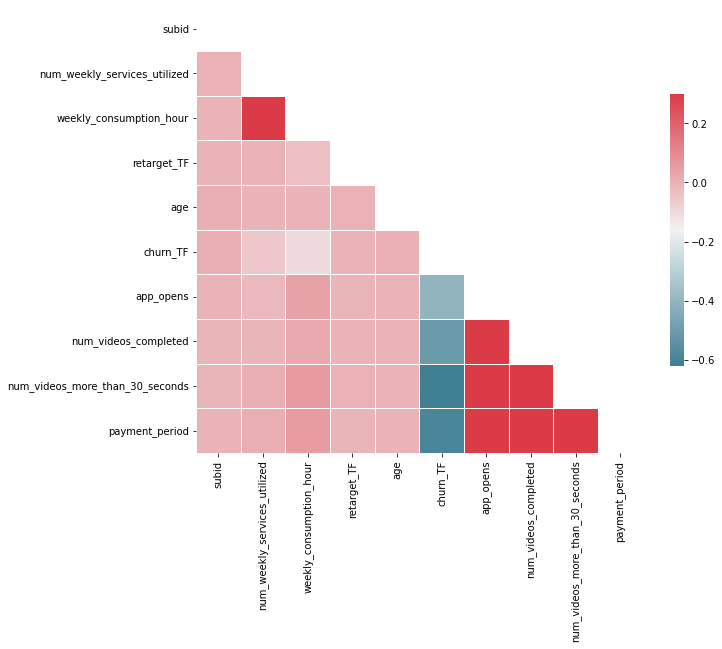

In [84]:
plt.figure(figsize=(10,10))
corr=churn.corr()
print(corr)
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,square=True,xticklabels=1,yticklabels=1,linewidths=0.5,cbar_kws={"shrink":0.5})
plt.yticks(rotation=0)
plt.show() 

#### LPM & Logistic Regression

In [48]:
churn1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86210 entries, 0 to 118586
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subid                            86210 non-null  int64  
 1   package_type                     86210 non-null  int32  
 2   num_weekly_services_utilized     86210 non-null  float64
 3   weekly_consumption_hour          86210 non-null  float64
 4   retarget_TF                      86210 non-null  int32  
 5   age                              86210 non-null  float64
 6   male_TF                          86210 non-null  int32  
 7   churn_TF                         86210 non-null  float64
 8   app_opens                        86210 non-null  float64
 9   num_videos_completed             86210 non-null  float64
 10  num_videos_more_than_30_seconds  86210 non-null  float64
 11  payment_period                   86210 non-null  float64
dtypes: float64(8), in

In [49]:
churn_list = list(churn1.columns)

churn_list.remove('churn_TF')
churn_list.remove('male_TF')
churn_list.remove('retarget_TF')
churn_list.remove('subid')
churn_list.remove('package_type')
churn_list

['num_weekly_services_utilized',
 'weekly_consumption_hour',
 'age',
 'app_opens',
 'num_videos_completed',
 'num_videos_more_than_30_seconds',
 'payment_period']

In [50]:
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))


churn1[churn_list] = churn1[churn_list].apply(max_min_scaler)

churn1

,subid,package_type,num_weekly_services_utilized,weekly_consumption_hour,retarget_TF,age,male_TF,churn_TF,app_opens,num_videos_completed,num_videos_more_than_30_seconds,payment_period
0,26844789,0,0.337838,0.681159,0,0.000013,1,1.0,0.001587,0.036620,0.022847,0.000000
2,29726122,1,0.203904,0.521739,0,0.000031,0,0.0,0.031746,0.512676,0.319859,0.168478
3,29726122,1,0.203904,0.521739,0,0.000031,0,0.0,0.031746,0.512676,0.319859,0.168478
4,20299962,1,0.301051,0.666667,0,0.000012,0,0.0,0.082540,0.236620,0.362039,0.168478
5,20299962,1,0.301051,0.666667,0,0.000012,0,0.0,0.082540,0.236620,0.362039,0.168478
...,...,...,...,...,...,...,...,...,...,...,...,...
118582,25492551,1,0.251351,0.623188,0,0.000016,0,1.0,0.002381,0.033803,0.022847,0.000000
118583,25835684,1,0.216216,0.565217,0,0.000022,0,1.0,0.024603,0.132394,0.103691,0.000000
118584,21434712,0,0.259459,0.608696,0,0.000019,0,1.0,0.012698,0.056338,0.063269,0.000000
118585,25843074,0,0.235736,0.594203,1,0.000025,0,1.0,0.057143,0.109859,0.214411,0.065217


In [51]:
df_train, df_test = model_selection.train_test_split(churn1, test_size=0.3)

In [52]:
y_col_name = 'churn_TF' # specify which column contains outcome variable y. Needs to be coded as binary True/False or 0/1
x_col_name = ['package_type','num_weekly_services_utilized','weekly_consumption_hour',
             'retarget_TF','age','male_TF','app_opens','num_videos_completed',
              'num_videos_more_than_30_seconds','payment_period']   # list of x covariates

In [53]:
add_constant_TF = True

# --- preprocess data for model routine format requirements
if add_constant_TF:
    x_col_name.append('const')
    df_train = sm.add_constant(df_train)
    df_test = sm.add_constant(df_test)

In [55]:
# --- fit linear probability model
lpm_model = sm.OLS(endog=df_train[y_col_name], exog=df_train[x_col_name])
lpm_results = lpm_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(lpm_results.summary())


RESULTS OF LOGIT MODEL FITTING

                            OLS Regression Results                            
Dep. Variable:               churn_TF   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     4057.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:24:26   Log-Likelihood:                -25732.
No. Observations:               60347   AIC:                         5.149e+04
Df Residuals:                   60336   BIC:                         5.159e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [56]:
# --- fit logistic regression
logit_model = sm.Logit(endog=df_train[y_col_name], exog=df_train[x_col_name])
logit_results = logit_model.fit()
print("\nRESULTS OF LOGIT MODEL FITTING\n")
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.425457
         Iterations 12

RESULTS OF LOGIT MODEL FITTING

                           Logit Regression Results                           
Dep. Variable:               churn_TF   No. Observations:                60347
Model:                          Logit   Df Residuals:                    60336
Method:                           MLE   Df Model:                           10
Date:                Thu, 22 Dec 2022   Pseudo R-squ.:                  0.3475
Time:                        16:24:47   Log-Likelihood:                -25675.
converged:                       True   LL-Null:                       -39351.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
package_type                    

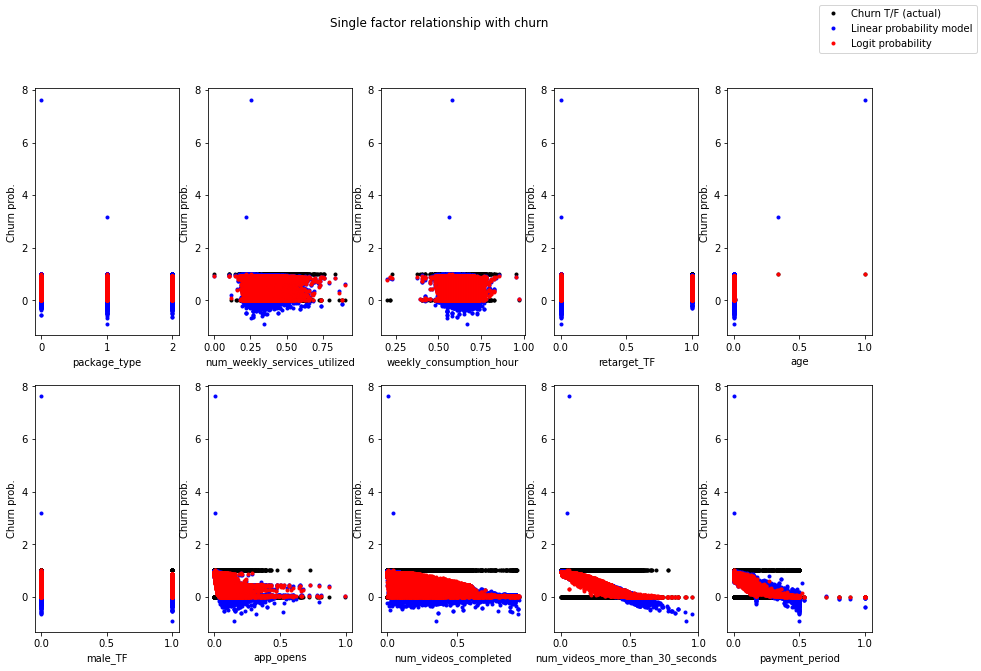

In [71]:
# ----- EVALUATE MODEL PERFORMANCE -----
# --- evaluate model predictions on test set graphically
df_test['prob_churn_lpm'] = lpm_results.predict(df_test[x_col_name])
df_test['prob_churn_logit'] = logit_results.predict(df_test[x_col_name])

# plot predictions vs. data
select_plot_coef = [x for x in x_col_name if x != 'const']
n_rows = 2
n_cols = math.ceil(len(select_plot_coef) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols)
fig.set_size_inches(15,10)
fig.suptitle('Single factor relationship with churn')
for i in range(n_rows):
    for j in range(n_cols):
        select_coef = select_plot_coef[i * n_cols + j]
        axes[i, j].plot(df_test[select_coef], df_test['churn_TF'], 'k.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_lpm'], 'b.')
        axes[i, j].plot(df_test[select_coef], df_test['prob_churn_logit'], 'r.')
        axes[i, j].set(xlabel=select_coef, ylabel='Churn prob.')
fig.legend(labels=['Churn T/F (actual)', 'Linear probability model', 'Logit probability'])


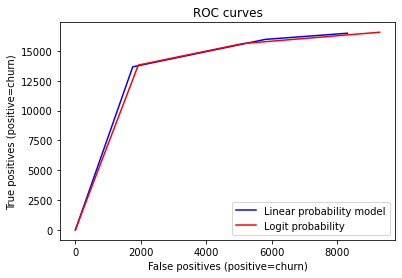

In [61]:
# --- evaluate model predictions using numerical quantification (ROC curves)
# make confusion matrices
logit_conf_mat, logit_false_positives, logit_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_logit'])
lpm_conf_mat, lpm_false_positives, lpm_true_positives = get_gini_info(df_test['churn_TF'], df_test['prob_churn_lpm'])

# plot ROC curves
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(lpm_false_positives, lpm_true_positives, 'b-')
ax1.plot(logit_false_positives, logit_true_positives, 'r-')
plt.title('ROC curves')
plt.xlabel('False positives (positive=churn)')
plt.ylabel('True positives (positive=churn)')
plt.legend(labels=['Linear probability model', 'Logit probability'])

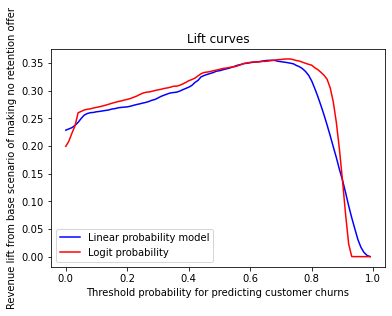

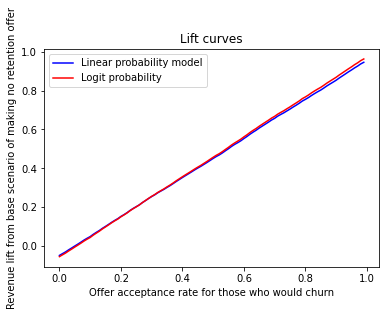

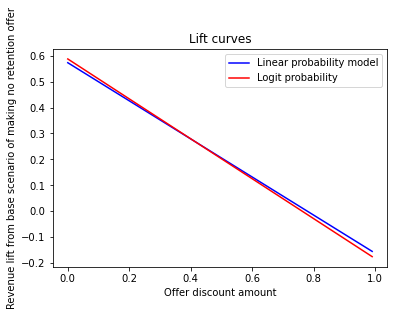

In [85]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.4
threshold = 0.7
base_price = 10
discount_amount = 0.3
cases = ['no_offer', 'lpm_offer', 'logit_offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])

# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind
# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind

# --- plot lift curves
# Threshold sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['lpm_offer'], 'b-')
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Acceptance rate sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['lpm_offer'], 'b-')
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])

# Discount amount sensitivity
fig = plt.figure()
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['lpm_offer'], 'b-')
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['logit_offer'], 'r-')
plt.title('Lift curves')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Linear probability model', 'Logit probability'])